In [1]:
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

# 시스템에 설치된 폰트 목록 출력
for font in fm.findSystemFonts(fontpaths=None, fontext='ttf'):
    print(fm.FontProperties(fname=font).get_name(), font)

Bell MT C:\Windows\Fonts\BELL.TTF
MT Extra C:\Windows\Fonts\MTEXTRA.TTF
Bodoni MT C:\Windows\Fonts\BOD_CI.TTF
Verdana C:\Windows\Fonts\verdanaz.ttf
Wingdings C:\Windows\Fonts\wingding.ttf
Century Schoolbook C:\Windows\Fonts\SCHLBKBI.TTF
Microsoft Tai Le C:\Windows\Fonts\taile.ttf
Hancom Gothic C:\Windows\Fonts\Hancom Gothic Regular.ttf
HCR Batang C:\Windows\Fonts\HANBatangB.ttf
Consolas C:\Windows\Fonts\consolai.ttf
Microsoft PhagsPa C:\Windows\Fonts\phagspab.ttf
Gill Sans MT C:\Windows\Fonts\GILB____.TTF
Baskerville Old Face C:\Windows\Fonts\BASKVILL.TTF
Leelawadee UI C:\Windows\Fonts\LeelUIsl.ttf
Han Santteut Dotum C:\Windows\Fonts\HanSantteutDotum-Regular.ttf
Bodoni MT C:\Windows\Fonts\BOD_BLAI.TTF
Goudy Old Style C:\Windows\Fonts\GOUDOSB.TTF
Bradley Hand ITC C:\Windows\Fonts\BRADHITC.TTF
Century Gothic C:\Windows\Fonts\GOTHIC.TTF
Arial C:\Windows\Fonts\arial.ttf
Garamond C:\Windows\Fonts\GARAIT.TTF
Dubai C:\Windows\Fonts\DUBAI-BOLD.TTF
Hancom Hoonminjeongeum_H C:\Windows\Fonts\Hanc

In [2]:
import pandas as pd
import numpy as np

# !pip install pykrx
from pykrx import stock

from tqdm import tqdm
import time

import seaborn as sns

In [3]:
df = pd.read_csv("./meta_data.csv")
df

,종목코드,종목명,시장구분,업종명,종가,대비,등락률,시가총액
0,120110,코오롱인더,KOSPI,화학,36550,-50,-0.14,1005822776050
1,150,두산,KOSPI,기타금융,137000,4100,3.09,2263765395000
2,24720,콜마홀딩스,KOSPI,기타금융,8250,20,0.24,303348540000
3,24720,콜마홀딩스,KOSPI,기타금융,8250,20,0.24,303348540000
4,4560,현대비앤지스틸,KOSPI,철강금속,20950,600,2.95,315901090450
...,...,...,...,...,...,...,...,...
141,4990,롯데지주,KOSPI,기타금융,26500,-300,-1.12,2780094780500
142,267260,HD현대일렉트릭,KOSPI,전기전자,255000,15000,6.25,9192019425000
143,1740,SK네트웍스,KOSPI,유통업,5540,-20,-0.36,1225879577080
144,5930,삼성전자,KOSPI,전기전자,78600,3100,4.11,469224908430000


In [4]:
df['종목코드'] = df['종목코드'].astype(str).str.zfill(6)

In [5]:
import numpy as np 
from statsmodels import regression
import statsmodels.api as sm 
import matplotlib.pyplot as plt 
import math
import pandas as pd 
import pandas_datareader as pdr 

In [6]:
sector_counts = df.groupby('업종명').size().reset_index(name='종목수')

print(sector_counts)

      업종명  종목수
0     건설업    6
1      기계    3
2    기타금융   20
3      보험    4
4   비금속광물    4
5    서비스업   11
6    섬유의복    1
7    운수장비   10
8   운수창고업    6
9     유통업   13
10     은행    2
11   음식료품    3
12    의약품    7
13  전기가스업    3
14   전기전자   13
15   종이목재    2
16     증권    5
17   철강금속    7
18    통신업    2
19     화학   24


In [7]:
import FinanceDataReader as fdr
import pandas as pd
import numpy as np
import networkx as nx
from tqdm import tqdm
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

import seaborn as sns
import networkx as nx

In [8]:
def create_graph_with_correlation(df, start, end):
    G = nx.Graph()
    
    # 모든 주식의 종가 데이터 가져오기
    stock_prices = {}
    for idx, row in tqdm(df.iterrows(), total=df.shape[0]):
        code = row["종목코드"]
        name = row["종목명"]
        sector = row["업종명"]
        try:
            asset = fdr.DataReader(code, start, end)
            stock_prices[code] = asset['Close']
        except:
            print(f"No data for {code} ({name})")
            continue
    
    if not stock_prices:
        raise ValueError("No valid stock data available for the given period.")
    
    # 가장 긴 공통 기간 찾기
    min_date = max([prices.index.min() for prices in stock_prices.values() if not prices.empty])
    max_date = min([prices.index.max() for prices in stock_prices.values() if not prices.empty])
    
    # 유효한 기간이 없는 경우 처리
    if pd.isna(min_date) or pd.isna(max_date):
        raise ValueError("No common dates available in the dataset.")
    
    # 공통 기간 내의 데이터를 기준으로 필터링
    common_dates = pd.date_range(start=min_date, end=max_date)
    print(f"Common date range: {min_date} to {max_date}")

    filtered_prices = {}
    for code in stock_prices:
        filtered_prices[code] = stock_prices[code].reindex(common_dates).dropna()
    
    # 시가총액 상위 50개 종목 선택
    valid_codes = [code for code in filtered_prices if len(filtered_prices[code]) > 0]
    top_50_df = df[df['종목코드'].isin(valid_codes)].nlargest(50, '시가총액')

    print(f"Valid codes after filtering: {len(valid_codes)}")
    print(f"Top 50 codes selected: {len(top_50_df)}")

    # 시가총액 상위 50개 종목에 대해 다시 종가 데이터를 가져오기
    stock_prices_top_50 = {code: filtered_prices[code] for code in top_50_df['종목코드']}

    for idx, row in tqdm(top_50_df.iterrows(), total=top_50_df.shape[0]):
        code = row["종목코드"]
        name = row["종목명"]
        sector = row["업종명"]
        
        # 그래프 노드에 종목명과 업종명 추가
        G.add_node(name, sector=sector)
    
    codes = list(stock_prices_top_50.keys())
    edge_count = 0
    for i in range(len(codes)):
        for j in range(i + 1, len(codes)):
            code_i = codes[i]
            code_j = codes[j]
            
            # 두 종목의 종가 데이터 가져오기
            prices_i = stock_prices_top_50[code_i]
            prices_j = stock_prices_top_50[code_j]
            
            # 상관 관계 계산
            if len(prices_i) > 1 and len(prices_j) > 1:  # 최소한 두 개의 데이터 포인트가 있는 경우
                correlation = prices_i.corr(prices_j)
                if not np.isnan(correlation) and correlation > 0.5:  # 상관 관계가 높은 경우만 엣지 추가
                    G.add_edge(df.loc[df['종목코드'] == code_i, '종목명'].values[0], 
                               df.loc[df['종목코드'] == code_j, '종목명'].values[0], 
                               weight=correlation)
                    edge_count += 1
    
    print(f"Total edges added: {edge_count}")
    return G


In [9]:
start_date = '2008-8-15'
end_date = '2008-10-15'

G = create_graph_with_correlation(df, start_date, end_date)

num_nodes = G.number_of_nodes()

print(f"Number of nodes in the graph: {num_nodes}")


  0%|          | 0/146 [00:00<?, ?it/s]

100%|██████████| 146/146 [02:31<00:00,  1.04s/it]


Common date range: 2008-08-18 00:00:00 to 2008-10-15 00:00:00
Valid codes after filtering: 86
Top 50 codes selected: 50


100%|██████████| 50/50 [00:00<00:00, 7101.53it/s]


Total edges added: 368
Number of nodes in the graph: 45


In [10]:
print("Edge weights:")
for (u, v, weight) in G.edges(data=True):
    print(f"({u}, {v}): {weight['weight']}")

Edge weights:
(삼성전자, LG화학): 0.5625198592154521
(삼성전자, LG전자): 0.737117795111622
(삼성전자, LG): 0.5823837257978008
(삼성전자, 한화에어로스페이스): 0.5323820399410327
(삼성전자, 삼성전기): 0.5430342960189813
(삼성전자, SK이노베이션): 0.6014139437737838
(삼성전자, 두산에너빌리티): 0.6371094684966201
(삼성전자, HD한국조선해양): 0.650302720086684
(삼성전자, 삼성중공업): 0.5441758172468887
(삼성전자, 포스코인터내셔널): 0.5097905937452151
(삼성전자, 대한항공): 0.6625850244263609
(삼성전자, LG생활건강): 0.526268940822082
(삼성전자, LG디스플레이): 0.7486563872075211
(삼성전자, 롯데케미칼): 0.627862666308625
(삼성전자, 현대건설): 0.6029770726246847
(삼성전자, 두산): 0.5316665271901608
(기아, SK텔레콤): 0.5482055716594832
(기아, S-Oil): 0.7403919424214368
(기아, 삼성증권): 0.5601605901439778
(NAVER, LG화학): 0.6094329375284967
(NAVER, 신한지주): 0.7498333847444578
(NAVER, 카카오): 0.689678035711887
(NAVER, 하나금융지주): 0.6126428661941173
(NAVER, LG): 0.5916737522026803
(NAVER, 한화에어로스페이스): 0.6632172450064703
(NAVER, 기업은행): 0.7888521319135405
(NAVER, SK이노베이션): 0.723666859976371
(NAVER, 두산에너빌리티): 0.7604390893074795
(NAVER, 고려아연): 0.74341656624709

In [11]:
font_path = "C:/Windows/Fonts/malgun.ttf"  # 폰트 파일 경로
font_prop = fm.FontProperties(fname=font_path)
plt.rc('font', family=font_prop.get_name())

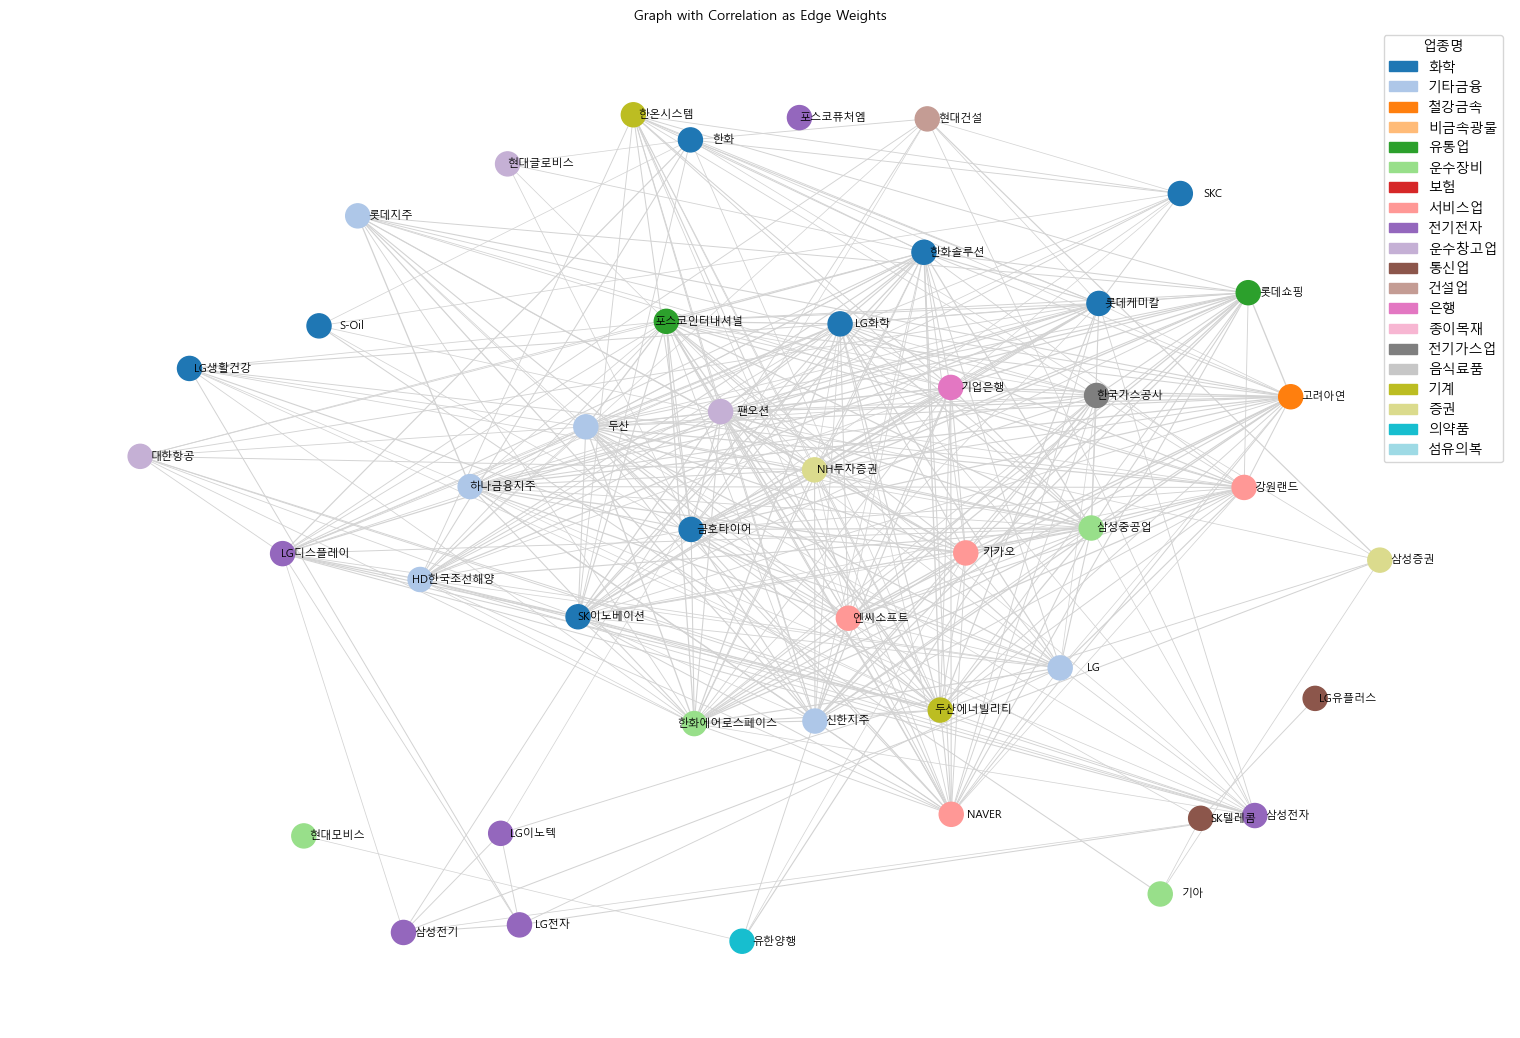

In [12]:
sectors = pd.unique(df["업종명"])
color_map = plt.get_cmap('tab20', len(sectors))
sector_color = {sector: color_map(i) for i, sector in enumerate(sectors)}

node_colors = [sector_color[G.nodes[node]['sector']] for node in G.nodes]

legend_patches = [mpatches.Patch(color=sector_color[sector], label=sector) for sector in sectors]

plt.figure(figsize=(15, 10))
pos = nx.spring_layout(G, k=2)  # k 값을 조정하여 노드 간 거리 조정
weights = nx.get_edge_attributes(G, 'weight').values()

# 라벨 위치 조정
labels = {node: node for node in G.nodes}
nx.draw(G, pos, with_labels=False, node_color=node_colors, edge_color='lightgray', width=list(weights))
for p in pos:  # 라벨을 노드 옆에 배치
    pos[p][0] += 0.05
nx.draw_networkx_labels(G, pos, labels, font_family=font_prop.get_name(), font_size=8)

plt.title('Graph with Correlation as Edge Weights', fontproperties=font_prop)
plt.legend(handles=legend_patches, loc='best', title='업종명', prop=font_prop)
plt.show()

# MST

In [13]:
mst = nx.minimum_spanning_tree(G)

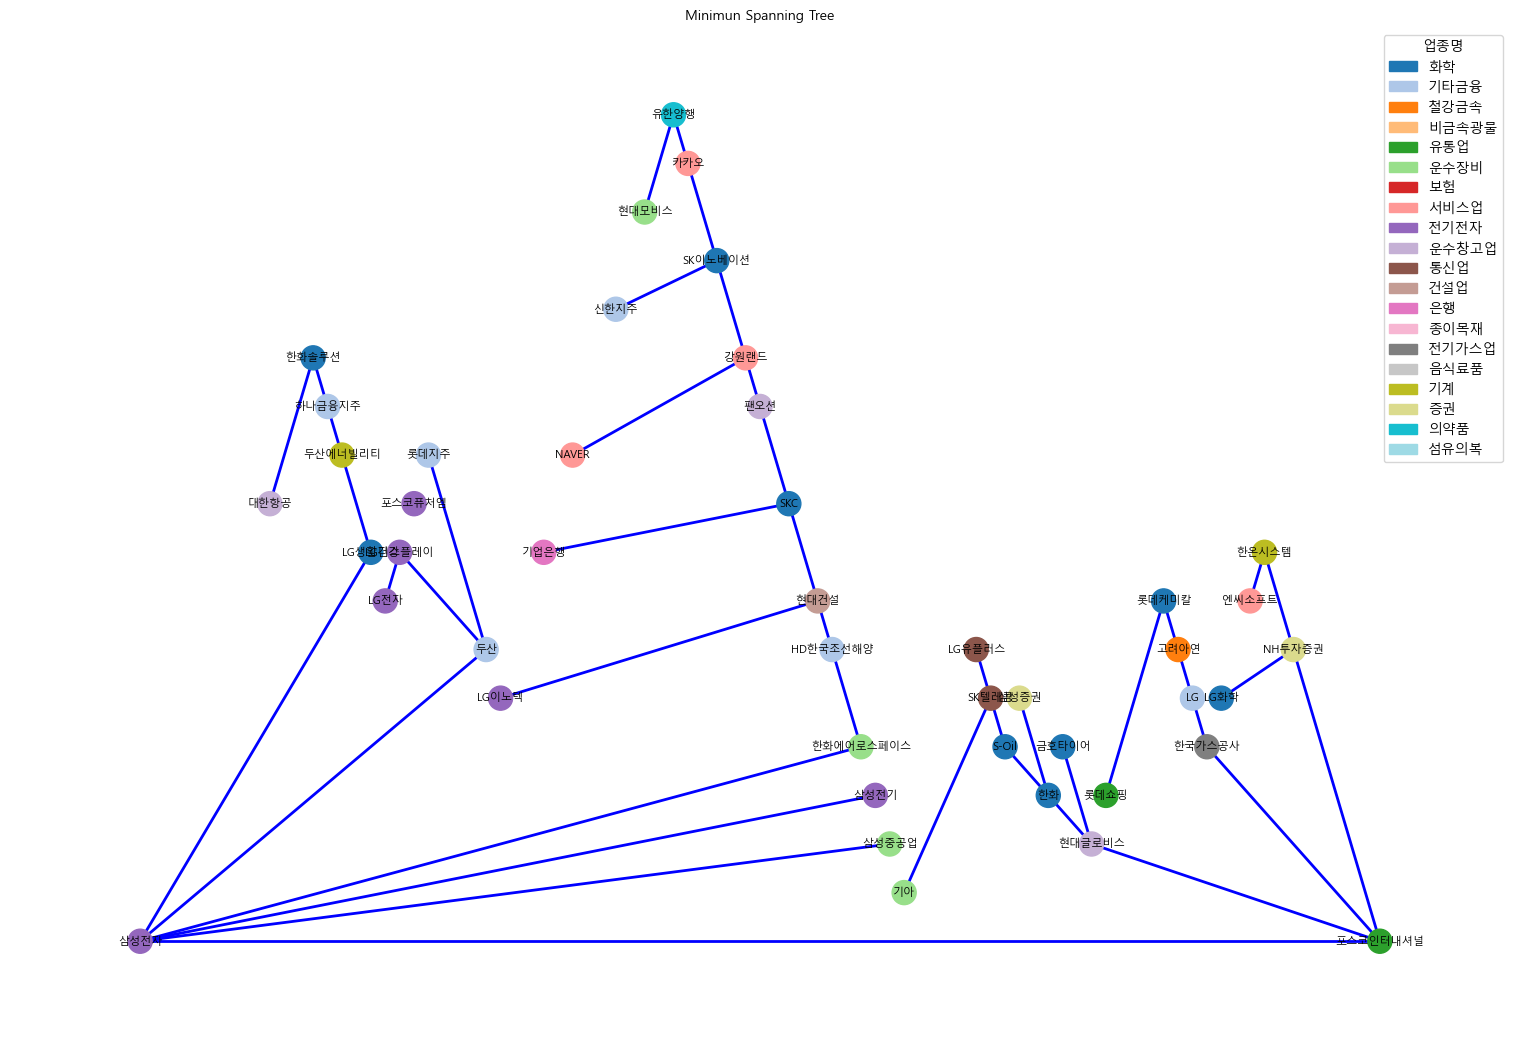

In [14]:
plt.figure(figsize=(15, 10))  
pos = nx.planar_layout(mst)  # 엣지 교차를 줄이기 위해 planar_layout 사용

nx.draw(mst, pos, with_labels=False, node_color=node_colors, edge_color='blue', width=2, node_size=300)
nx.draw_networkx_labels(mst, pos, labels={node: node for node in mst.nodes()}, font_family=font_prop.get_name(), font_size=8)
plt.title("Minimun Spanning Tree", fontproperties=font_prop)
plt.legend(handles=legend_patches, loc='best', title='업종명', prop=font_prop)
plt.show()

# Centrality Analysis

In [15]:
degree_centrality = nx.degree_centrality(G)
betweenness_centrality = nx.betweenness_centrality(G)
closeness_centrality = nx.closeness_centrality(G)
eigenvector_centrality = nx.eigenvector_centrality(G)

In [16]:
centrality_df = pd.DataFrame({
    '종목코드': list(G.nodes),
    '업종명': [G.nodes[node]['sector'] for node in G.nodes],
    'Degree Centrality': [degree_centrality[node] for node in G.nodes],
    'Betweenness Centrality': [betweenness_centrality[node] for node in G.nodes],
    'Closeness Centrality': [closeness_centrality[node] for node in G.nodes],
    'Eigenvector Centrality': [eigenvector_centrality[node] for node in G.nodes]
})

In [17]:
for centrality in ['Degree Centrality', 'Betweenness Centrality', 'Closeness Centrality', 'Eigenvector Centrality']:
    print(f"Top 10 {centrality}")
    display(centrality_df[['종목코드', '업종명', centrality]].nlargest(10, centrality))
    print("\n")

Top 10 Degree Centrality


,종목코드,업종명,Degree Centrality
16,두산에너빌리티,기계,0.636364
21,포스코인터내셔널,유통업,0.636364
40,두산,기타금융,0.636364
11,한화에어로스페이스,운수장비,0.613636
20,삼성중공업,운수장비,0.613636
31,한화솔루션,화학,0.613636
3,LG화학,화학,0.590909
15,SK이노베이션,화학,0.590909
41,팬오션,운수창고업,0.590909
44,금호타이어,화학,0.590909




Top 10 Betweenness Centrality


,종목코드,업종명,Betweenness Centrality
19,S-Oil,화학,0.103437
42,한화,화학,0.099728
28,SKC,화학,0.073774
26,LG디스플레이,전기전자,0.045723
13,SK텔레콤,통신업,0.044397
25,유한양행,의약품,0.044397
16,두산에너빌리티,기계,0.042887
29,롯데케미칼,화학,0.041229
31,한화솔루션,화학,0.040030
15,SK이노베이션,화학,0.037558




Top 10 Closeness Centrality


,종목코드,업종명,Closeness Centrality
16,두산에너빌리티,기계,0.656605
31,한화솔루션,화학,0.646503
15,SK이노베이션,화학,0.636708
41,팬오션,운수창고업,0.627205
21,포스코인터내셔널,유통업,0.609025
40,두산,기타금융,0.609025
11,한화에어로스페이스,운수장비,0.600325
20,삼성중공업,운수장비,0.600325
29,롯데케미칼,화학,0.600325
3,LG화학,화학,0.591869




Top 10 Eigenvector Centrality


,종목코드,업종명,Eigenvector Centrality
40,두산,기타금융,0.219585
20,삼성중공업,운수장비,0.217345
21,포스코인터내셔널,유통업,0.216153
16,두산에너빌리티,기계,0.216150
11,한화에어로스페이스,운수장비,0.214794
41,팬오션,운수창고업,0.212055
3,LG화학,화학,0.211373
44,금호타이어,화학,0.210902
31,한화솔루션,화학,0.209768
2,NAVER,서비스업,0.204872


# Influence Maximization

In [18]:
import random

# 독립적 연접 모델을 사용한 영향 평가 함수
def independent_cascade(G, seed_nodes, steps=1000):
    influenced_nodes = set(seed_nodes)
    new_active = set(seed_nodes)
    for _ in range(steps):
        if not new_active:
            break
        next_active = set()
        for node in new_active:
            for neighbor in G.neighbors(node):
                if neighbor not in influenced_nodes and random.random() < G[node][neighbor]['weight']:
                    next_active.add(neighbor)
        influenced_nodes.update(next_active)
        new_active = next_active
    return len(influenced_nodes)

In [19]:
# Greedy Algorithm을 사용한 시드 노드 선택
def greedy_algorithm(G, k, steps=1000):
    seed_nodes = []
    for _ in tqdm(range(k)):
        best_node = None
        max_influence = -1
        for node in tqdm(G.nodes):
            if node not in seed_nodes:
                influence = independent_cascade(G, seed_nodes + [node], steps)
                if influence > max_influence:
                    best_node = node
                    max_influence = influence
        seed_nodes.append(best_node)
    return seed_nodes

In [20]:
# 시드 노드 수 설정
k = 1

# Greedy Algorithm을 사용하여 시드 노드 선택
seed_nodes = greedy_algorithm(G, k)
print(f"Selected seed nodes: {seed_nodes}")

100%|██████████| 1/1 [00:00<00:00, 79.02it/s]

Selected seed nodes: ['카카오']


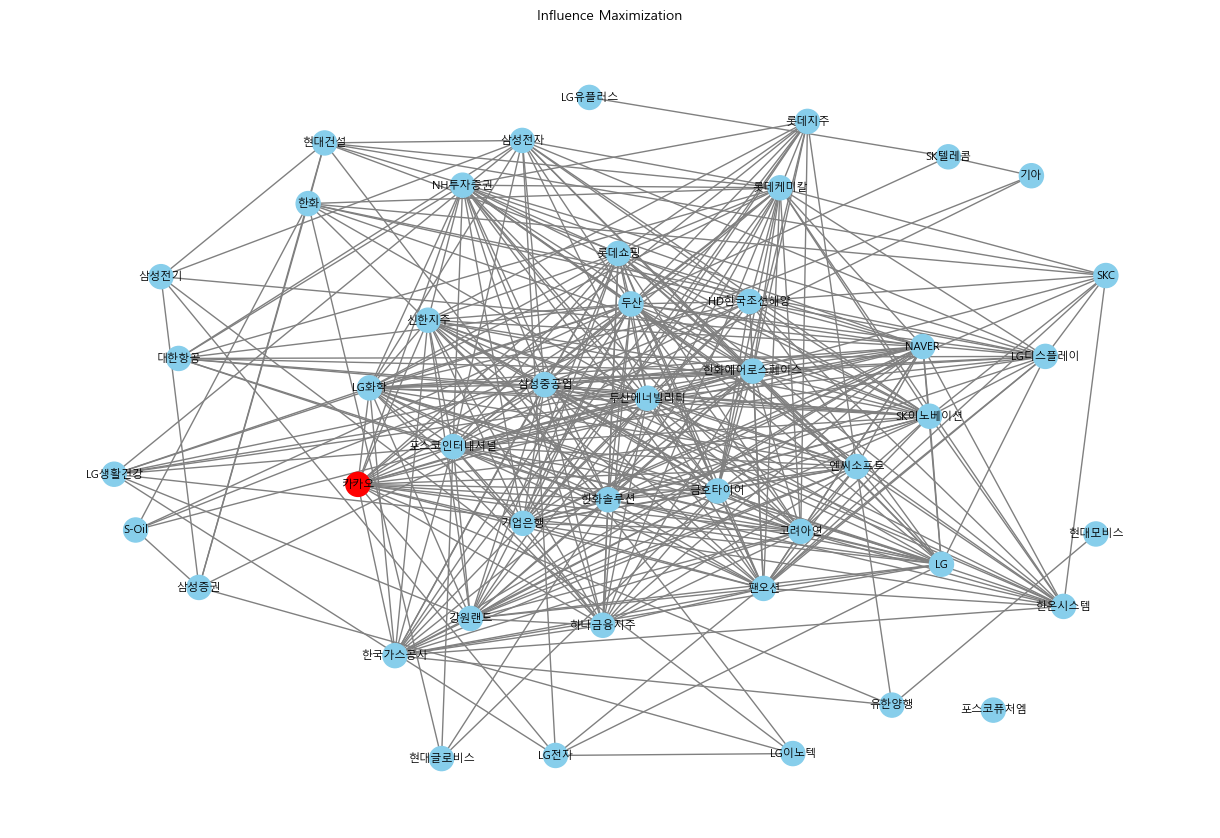

In [21]:
font_path = "C:/Windows/Fonts/malgun.ttf"  # 폰트 파일 경로
font_prop = fm.FontProperties(fname=font_path)
plt.rc('font', family=font_prop.get_name())

# 시각화 (선택된 시드 노드를 강조하여 표시)
pos = nx.spring_layout(G, k=2)
node_colors = ['red' if node in seed_nodes else 'skyblue' for node in G.nodes]

plt.figure(figsize=(12, 8))
nx.draw(G, pos, with_labels=True, node_color=node_colors, edge_color='gray', node_size=300, font_size=8, font_family=font_prop.get_name())  # 노드 크기 조정
plt.title("Influence Maximization", fontproperties=font_prop)
plt.show()

# Community Detection

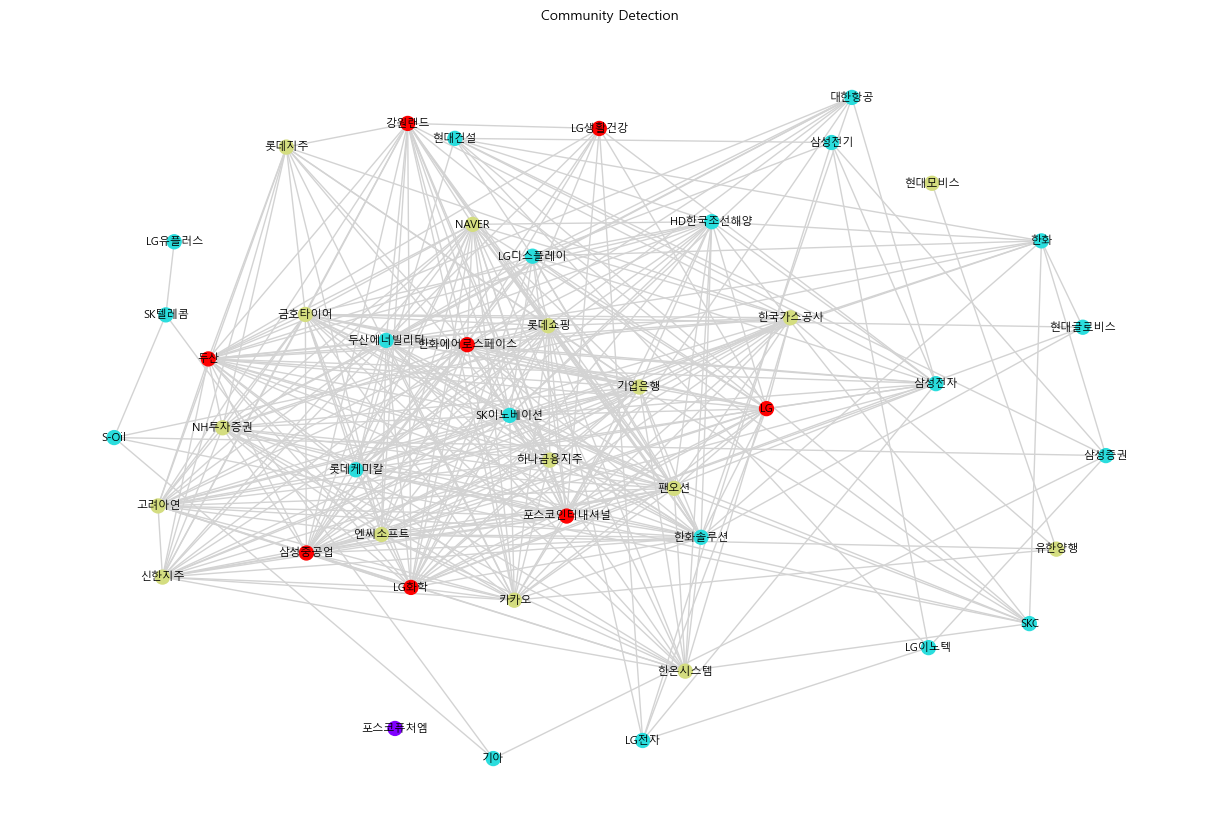

In [22]:
import community as community_louvain

partition = community_louvain.best_partition(G)

# 커뮤니티별로 노드 색상 지정
colors = [partition[node] for node in G.nodes()]

# 한글 폰트 설정
font_path = "C:/Windows/Fonts/malgun.ttf"  # 폰트 파일 경로
font_prop = fm.FontProperties(fname=font_path)
plt.rc('font', family=font_prop.get_name())

# 그래프 시각화
pos = nx.spring_layout(G, k=2)
plt.figure(figsize=(12, 8))

nx.draw(G, pos, node_color=colors, with_labels=True, cmap=plt.cm.rainbow, node_size=100, edge_color='lightgray', font_size=8, font_family=font_prop.get_name())
plt.title("Community Detection", fontproperties=font_prop)

plt.show()

In [23]:
community_df = pd.DataFrame.from_dict(partition, orient='index', columns=['커뮤니티'])
community_df['종목명'] = community_df.index
community_df.reset_index(drop=True, inplace=True)

# 업종명 추가
community_df = community_df.merge(df[['종목명', '업종명']], on='종목명')

# 커뮤니티와 업종명 카운트 피벗 테이블 생성
pivot_table = community_df.pivot_table(index='커뮤니티', columns='업종명', aggfunc='size', fill_value=0)

# 커뮤니티 이름을 "community 1", "community 2" 형식으로 변경
pivot_table.index = [f"community {i+1}" for i in range(len(pivot_table))]

# 결과 출력
pivot_table

업종명,건설업,기계,기타금융,서비스업,운수장비,운수창고업,유통업,은행,의약품,전기가스업,전기전자,증권,철강금속,통신업,화학
community 1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
community 2,1,1,1,0,1,3,0,0,0,0,6,1,0,2,8
community 3,0,1,3,4,1,1,1,1,1,1,0,1,1,0,1
community 4,0,0,2,1,2,0,1,0,0,0,0,0,0,0,2
